# Test of MoGe and SAM2

### Imports

In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from moge.model.v2 import MoGeModel
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from utils import get_integer_segments, plot_region_numbers, triangulate_segments

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Define devices and functions

In [2]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Load models

In [4]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [5]:
moge_model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device0)

### Add input image

In [6]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv2.cvtColor(cv2.imread("../data/mustard360/images/frame_0.png"), cv2.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)
input_image_array  = np.array(input_image)

### Infer segmentation masks and estimate geometry

In [7]:
masks = mask_generator.generate(input_image_array)

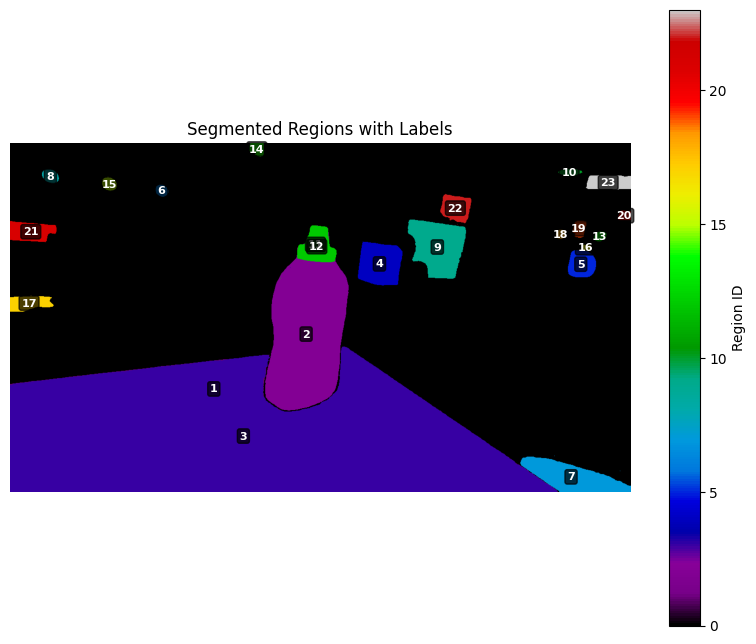

In [8]:
segmentation_masks = [mask['segmentation'] for mask in masks]
segmentation_masks = np.array(segmentation_masks)

seg = get_integer_segments(segmentation_masks)
plot_region_numbers(seg)

In [9]:
output = moge_model.infer(input_image_tensor)
"""
`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",
The maps are in the same size as the input image. 
{
    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.
    "depth": (H, W),        # depth map
    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)
    "mask": (H, W),         # a binary mask for valid pixels. 
    "intrinsics": (3, 3),   # normalized camera intrinsics
}
"""

'\n`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",\nThe maps are in the same size as the input image. \n{\n    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.\n    "depth": (H, W),        # depth map\n    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)\n    "mask": (H, W),         # a binary mask for valid pixels. \n    "intrinsics": (3, 3),   # normalized camera intrinsics\n}\n'

### Show outputs

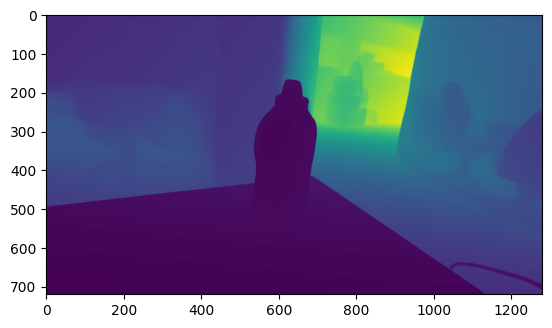

In [10]:
plt.imshow(output["depth"].cpu())

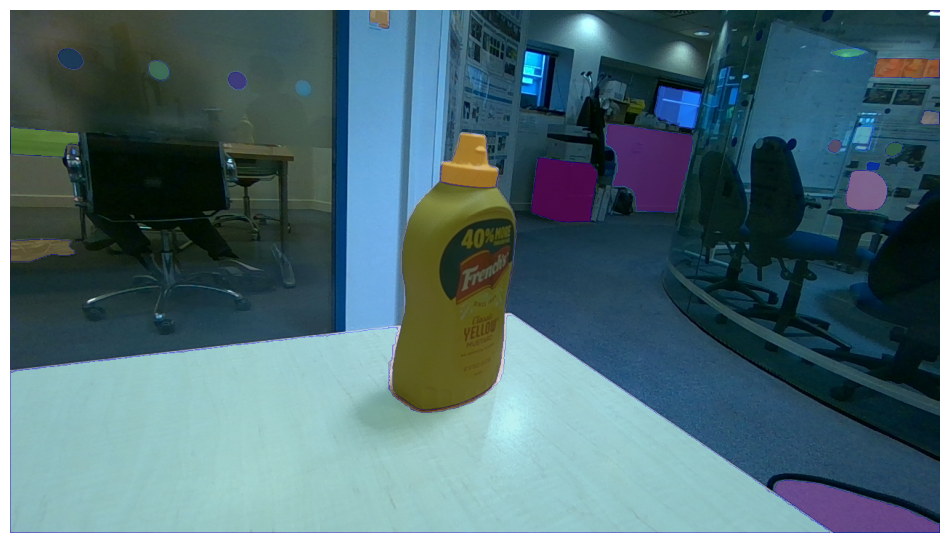

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 

In [12]:
import open3d as o3d
verts = output['points'].reshape((-1,3)).cpu().numpy()
print(verts)

pcd = o3d.geometry.PointCloud()
pcd.points  = o3d.utility.Vector3dVector(verts)

o3d.visualization.draw_geometries([pcd])

[[-1.0902634  -0.61283684  1.0412884 ]
 [-1.0904577  -0.6139064   1.0431057 ]
 [-1.0890667  -0.61408484  1.0434089 ]
 ...
 [ 1.2227261   0.68973494  1.1714648 ]
 [ 1.2277492   0.6912131   1.1739752 ]
 [ 1.2287753   0.69111454  1.1738079 ]]


In [13]:
tris = triangulate_segments(verts, seg)

Triangulating row 0
Triangulating row 1
Triangulating row 2
Triangulating row 3
Triangulating row 4
Triangulating row 5
Triangulating row 6
Triangulating row 7
Triangulating row 8
Triangulating row 9
Triangulating row 10
Triangulating row 11
Triangulating row 12
Triangulating row 13
Triangulating row 14
Triangulating row 15
Triangulating row 16
Triangulating row 17
Triangulating row 18
Triangulating row 19
Triangulating row 20
Triangulating row 21
Triangulating row 22
Triangulating row 23
Triangulating row 24
Triangulating row 25
Triangulating row 26
Triangulating row 27
Triangulating row 28
Triangulating row 29
Triangulating row 30
Triangulating row 31
Triangulating row 32
Triangulating row 33
Triangulating row 34
Triangulating row 35
Triangulating row 36
Triangulating row 37
Triangulating row 38
Triangulating row 39
Triangulating row 40
Triangulating row 41
Triangulating row 42
Triangulating row 43
Triangulating row 44
Triangulating row 45
Triangulating row 46
Triangulating row 47
Tr

KeyboardInterrupt: 